<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [103]:
!ls

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [3]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
train_df = pd.read_csv('input/train-balanced-sarcasm.csv')

In [106]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [107]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


Some comments are missing, so we drop the corresponding rows.

In [108]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [109]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [110]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

### Analyze the dataset

Distribution of lengths for sarcastic and normal comments is almost the same.

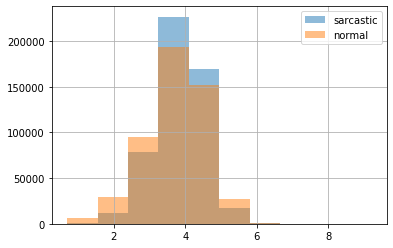

In [111]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend()

In [112]:
from wordcloud import WordCloud, STOPWORDS

In [113]:
wordcloud = WordCloud(background_color='black', stopwords= STOPWORDS,
                     max_words = 300, max_font_size=100,
                     random_state = 13, width=800, height=400)


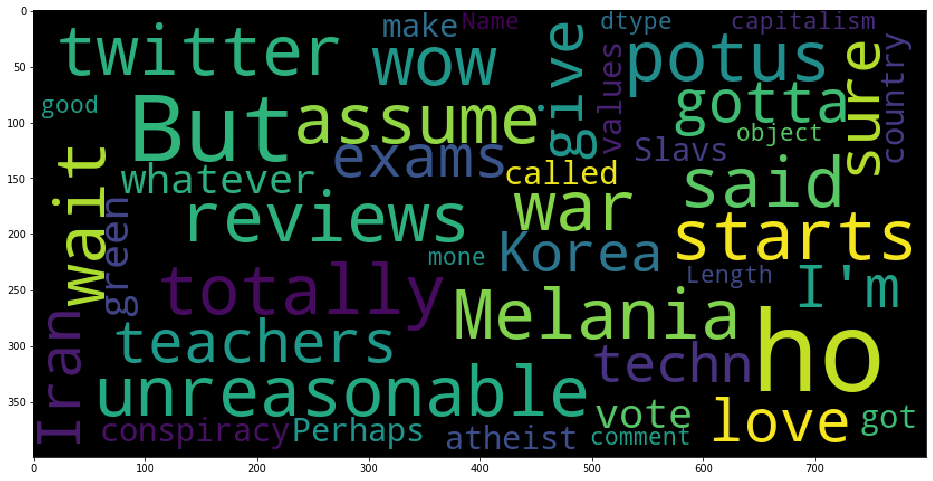

In [114]:
plt.figure(figsize=(16,12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud)

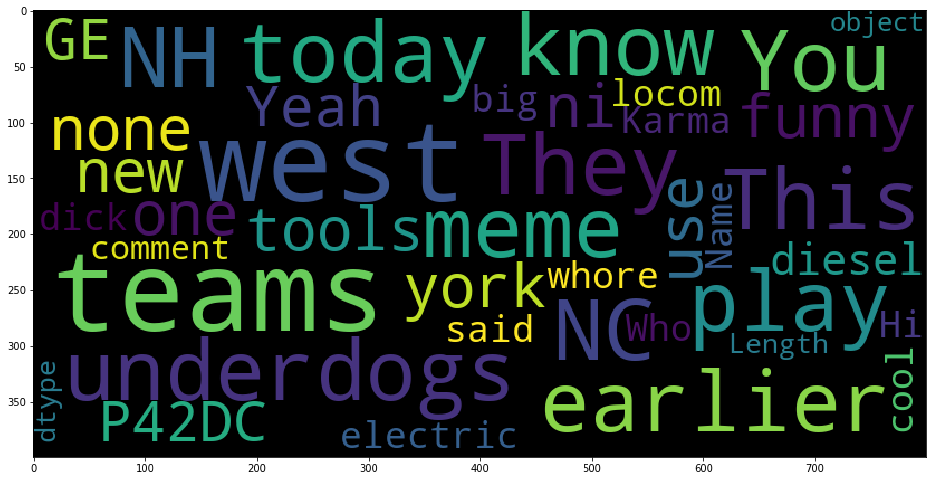

In [115]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

Let's analyze whether some subreddits are more "sarcastic" on average than others

In [117]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [118]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


The same for authors doesn't yield much insight. Except for the fact that somebody's comments were sampled - we can see the same amounts of sarcastic and non-sarcastic comments.

In [120]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [121]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [125]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


(2) Build a Tf-Idf + logistic regression pipeline to predict sarcasm based on   `comment`

In [156]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(np.concatenate((valid_texts, train_texts), axis=0))
X_train_tfv = tfv.transform(train_texts)
X_test_tfv = tfv.transform(valid_texts)

In [157]:
# Fitting a simplpe Logistic Regression on TF-IDF
clf = LogisticRegression(C=1.0, random_state = 13)
clf.fit(X_train_tfv, y_train)
predictions = clf.predict(X_test_tfv)

accuracy_score(predictions, y_valid)

C:\Users\Brux\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.689311974166383

In [158]:
# The same but with Pipeline 

In [159]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

#multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

#sklean's pipeline
clf = Pipeline(steps=[('tf_idf',tfv), ('logit', logit) ])

In [160]:
%%time
clf.fit(train_texts, y_train)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 1min 13s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.3s finished


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=3, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=1,
                                 stop_words='english', strip_accents='unicode',
                                 sublinear_tf=1, token_pattern='\\w{1,}',
                                 tokenizer=None, use_idf=1, vocabulary=None)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
      

In [161]:
%%time
predictions = clf.predict(valid_texts)
accuracy_score(predictions, y_valid)

Wall time: 6.08 s


0.687198746309766

In [162]:
confusion_matrix(y_valid, predictions, normalize='true')

array([[0.72205244, 0.27794756],
       [0.34763344, 0.65236656]])

Plot the words/bigrams which a most predictive of sarcasm (you can use eli5 for that)

In [163]:
import eli5

eli5.show_weights(clf, top=13)

Weight?,Feature
+7.728,obviously
+6.947,totally
+6.765,clearly
+5.941,dare
+5.853,m sure
+5.495,duh
+5.289,b b
+5.289,t possibly
+5.214,gee
+5.087,good thing


###### Part 4. Improving the model

In [138]:
subreddits = train_df['subreddit']
train_subreddits, test_subreddits = train_test_split(subreddits, random_state = 17)

We'll have separate Tf-Idf vectorizers for comments and for subreddits. It's possible to stick to a pipeline as well, but in that case it becomes a bit less straightforward. [Example](https://stackoverflow.com/questions/36731813/computing-separate-tfidf-scores-for-two-different-columns-using-sklearn)

In [139]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

Do transformations separately for comments and subreddits. 

In [140]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_test_texts = tf_idf_texts.transform(valid_texts)

Wall time: 39 s


In [141]:
X_train_texts.shape, X_test_texts.shape

((758079, 50000), (252694, 50000))

In [142]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_test_subreddits = tf_idf_subreddits.transform(test_subreddits)

Wall time: 3.9 s


In [144]:
X_train_subreddits.shape, X_test_subreddits.shape

((758079, 13255), (252694, 13255))

Then, stack all features together.

In [146]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_test = hstack([X_test_texts,X_test_subreddits])

In [147]:
X_train.shape, X_test.shape

((758079, 63255), (252694, 63255))

Train the same logistic regression.

In [149]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.9s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [152]:
%%time
test_pred = logit.predict(X_test)

Wall time: 136 ms


In [153]:
accuracy_score(y_valid, test_pred)

0.7237647114692078

As we can see, accuracy slightly increased.

In [ ]:
a